# Navigation

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

In the repository, it is already provided the linux version (with 1 or 20 agents):
```
env = UnityEnvironment(file_name="Reacher_Linux/Reacher.x86_64")
env = UnityEnvironment(file_name="Reacher_Linux_20/Reacher.x86_64")
```

In [2]:
env = UnityEnvironment(file_name="Reacher_Linux_20/Reacher.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains 20 agents.  At each time step, it has four continuous actions to pick within -1 and +1.

The state space has `33` dimensions.  A reward is given whenever a step is inside the target ball. 

Run the code cell below to print some information about the environment.

In [4]:
env_info = env.reset(train_mode=True)[brain_name]

NUM_AGENTS = len(env_info.agents)
STATE_SIZE = env_info.vector_observations.shape[1]
ACTION_SIZE = brain.vector_action_space_size

print('Agents count:', NUM_AGENTS)
print('State size:', STATE_SIZE)
print('Action size:', ACTION_SIZE)

Agents count: 20
State size: 33
Action size: 4


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [5]:
env_info = env.reset(train_mode=True)[brain_name]  # reset the environment (set train_mode=False to be slow)
state = env_info.vector_observations[0]            # get the current state
scores = np.zeros(NUM_AGENTS)                       # initialize the score
dones = np.zeros(NUM_AGENTS)                        # initialize the done
while not np.any(dones):
    actions = np.random.randn(NUM_AGENTS, ACTION_SIZE)        
    actions = np.clip(actions, -1,1)               # random actions but clipped to -1,1
    env_info = env.step(actions)[brain_name]       # send the action to the environment
    rewards = env_info.rewards                      # get the reward
    dones = env_info.local_done                  # see if episode has finished
    scores += rewards                                # update the score

total_score = np.mean(scores) 
print("Score: {}".format(total_score))

Score: 0.16399999633431434


### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```


Let's set up some parameters, feel free to change them.





In [6]:
import torch
import random
import torch.nn as nn

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# the hyperparameters
GAMMA = 0.99
TAU = 0.95
LR = 2e-4
ENTROPY_BETA = 0.001
NUM_STEPS = 512
BATCH_SIZE = 128
PPO_UPDATES = 4
EPS = 0.2

# the model
FC1 = 64
FC2 = 64
LOG_STD = 0.0

ACTOR_FUNCTION = nn.Tanh()  # function to use in actor network

TARGET = 30

Time to create our agent.

It is a basic actor critic network.
- The critic is for estimating the value given a state.
- The actor is for choosing the action given a state.

Note that the `ACTOR_FUNCTION` is `nn.Tanh` that will leads to -1,1.
That's exactly what our environment is expecting. No need to rescale it!

However this is not enough, the network gives us back a mean value. We sample the action using a gaussian distribution `LOG_STD`. 

Don't worry, to be safe we will clip the output before giving it to the step function of the environment.


In [7]:
from torch.distributions import Normal

class Agent(nn.Module):
    def __init__(self):
        super(Agent, self).__init__()
        self.critic = nn.Sequential(
            nn.Linear(STATE_SIZE, FC1),
            nn.ReLU(),
            nn.Linear(FC1, FC2),
            nn.ReLU(),
            nn.Linear(FC2, 1),
        )
        self.actor = nn.Sequential(
            nn.Linear(STATE_SIZE, FC1),
            nn.ReLU(),
            nn.Linear(FC1, FC2),
            nn.ReLU(),
            nn.Linear(FC2, ACTION_SIZE),
            ACTOR_FUNCTION
        )

        self.log_std = nn.Parameter(torch.ones(1, ACTION_SIZE) * LOG_STD)

    def value(self, state):
        return self.critic(state)

    def dist(self, state):
        action_mean = self.actor(state)
        std = self.log_std.exp().expand_as(action_mean)
        return Normal(action_mean, std)

    def act(self, state):
        dist = self.dist(state)
        value = self.value(state)

        action = dist.sample()
        log_prob = dist.log_prob(action)
        entropy = dist.entropy().mean()

        return action, log_prob, entropy, value
    
    def save(self, path):
        torch.save(self.state_dict(), path)
        
    def load(self, path):
        self.load_state_dict(torch.load(path))

Let's write a small helper function to evaluate our agent.
We will use it also during training to see how the agent is doing and if it is able to reach our `TARGET`

In [8]:
def evaluate_agent(agent, fast=True):
    env_info = env.reset(train_mode=fast)[brain_name]
    states = torch.Tensor(env_info.vector_observations).to(device)

    scores = np.zeros(NUM_AGENTS)
    dones = np.zeros(NUM_AGENTS)
    while not np.any(dones):
        actions, _, _, _ = agent.act(states)
        env_info = env.step(np.clip(actions.cpu().numpy(), -1, 1))[brain_name]
        states = torch.Tensor(env_info.vector_observations).to(device)
        rewards = env_info.rewards
        dones = env_info.local_done
        scores += rewards        

    total_score = np.mean(scores)
    return total_score

agent = Agent()

score = evaluate_agent(agent)
print("Score: {}".format(score))

Score: 0.12649999717250465


Not any better than the random agent.

Time to train it!

A couple of helper function first:
- run_rollout(agent) performs some steps (`NUM_STEPS`) and save it it a memory. This is the data we use for training
- compute_returns(..) computes the expected returns based on 

In [9]:
def compute_returns(final_value, rewards, multipliers, values):
    gae = 0

    values = values.reshape((NUM_STEPS, NUM_AGENTS, 1)).to(device).detach()
    next_value = final_value.reshape((NUM_AGENTS, 1)).to(device).detach()
    returns = torch.zeros((NUM_STEPS, NUM_AGENTS, 1)).to(device).detach()
    for step in reversed(range(NUM_STEPS)):
        delta = rewards[step] + GAMMA * next_value * \
            multipliers[step] - values[step]
        gae = delta + GAMMA * TAU * multipliers[step] * gae
        returns[step] = gae + values[step]
        next_value = values[step]
    return returns


def run_rollout(agent):
    states = torch.zeros((NUM_STEPS, NUM_AGENTS, STATE_SIZE)).to(device)
    actions = torch.zeros((NUM_STEPS, NUM_AGENTS, ACTION_SIZE)).to(device)
    log_probs = torch.zeros((NUM_STEPS, NUM_AGENTS, ACTION_SIZE)).to(device)
    rewards = torch.zeros((NUM_STEPS, NUM_AGENTS, 1)).to(device)
    multipliers = torch.zeros((NUM_STEPS, NUM_AGENTS, 1)).to(device)
    values = torch.zeros((NUM_STEPS, NUM_AGENTS, 1)).to(device)

    env_info = env.reset(train_mode=True)[brain_name]
    state = torch.Tensor(env_info.vector_observations).to(device)
    for t in range(NUM_STEPS):
        action, log_prob, _, value = agent.act(state)
        env_info = env.step(np.clip(action.cpu().numpy(), -1, 1))[brain_name]

        next_state = torch.Tensor(env_info.vector_observations).to(device)
        reward = torch.tensor(env_info.rewards).unsqueeze(1).detach()
        done = torch.tensor(1-np.asarray(env_info.local_done)
                            ).unsqueeze(1).detach()

        states[t] = state.detach()
        actions[t] = action.detach()
        log_probs[t] = log_prob.detach()
        rewards[t] = reward
        multipliers[t] = done
        values[t] = value.detach()

        state = next_state

    _, _, _, next_value = agent.act(next_state)
    returns = compute_returns(next_value, rewards, multipliers, values)

    returns = returns.reshape((NUM_STEPS*NUM_AGENTS, 1)).detach()
    log_probs = log_probs.reshape((-1, ACTION_SIZE)).detach()
    values = values.reshape((-1, 1)).detach()
    states = states.reshape((-1, STATE_SIZE)).detach()
    actions = actions.reshape((-1, ACTION_SIZE)).detach()
    advantages = (returns - values).to(device).detach()
    
    return states, actions, log_probs, returns, advantages        

We can finally train the agent and save the weights.
Iteratively:
- we create a rollout, this is the memory we train on
- we then optimize the weights, we can perform PPO_UPDATES before discarding the memory. Remember the PPO is clipping the surrogate function so the new policy will be close enough to the one used for creating the rollout.

In [10]:
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from collections import deque

def train(agent):
    optimizer = optim.Adam(agent.parameters(), lr=LR)
    
    scores = []
    scores_window = deque(maxlen=100)
    score = evaluate_agent(agent)    
    scores.append(score)
    scores_window.append(score)
    
    e = 0    
    print("Episode:", e, "Score:", score, "Mean window score:", np.mean(scores_window))
    while (np.mean(scores_window) < TARGET):
        e += 1
        r_states, r_actions, r_log_probs, r_returns, r_advantages = run_rollout(
            agent)

        dataset = TensorDataset(
            r_states, r_actions, r_log_probs, r_returns, r_advantages)
        loader = DataLoader(dataset, batch_size=BATCH_SIZE)

        for _ in range(PPO_UPDATES):
            for (states, actions, old_log_probs, returns, advantages) in loader:
                dist = agent.dist(states)
                values = agent.value(states)
                entropy = dist.entropy().mean()
                new_log_probs = dist.log_prob(actions)

                ratios = (new_log_probs - old_log_probs).exp()
                surr = torch.clamp(ratios, 1.0 - EPS, 1.0 + EPS) * advantages

                loss1 = - torch.min(ratios * advantages, surr).mean()
                loss2 = (returns - values).pow(2).mean()

                loss = 0.5 * loss1 + loss2 - ENTROPY_BETA * entropy

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
        score = evaluate_agent(agent)        
        scores.append(score)
        scores_window.append(score)
        print("Episode:", e, "Score:", score, "Mean window score:", np.mean(scores_window))

    return scores

scores = train(agent)
agent.save("ppo.pth")

Episode: 0 Score: 0.0824999981559813 Mean window score: 0.0824999981559813
Episode: 1 Score: 0.21399999521672725 Mean window score: 0.14824999668635427
Episode: 2 Score: 0.23499999474734068 Mean window score: 0.1771666627066831
Episode: 3 Score: 0.4359999902546406 Mean window score: 0.24187499459367245
Episode: 4 Score: 0.38749999133870006 Mean window score: 0.270999993942678
Episode: 5 Score: 0.4584999897517264 Mean window score: 0.30224999324418605
Episode: 6 Score: 0.5434999878518283 Mean window score: 0.33671427818813493
Episode: 7 Score: 0.7414999834261835 Mean window score: 0.38731249134289103
Episode: 8 Score: 1.0129999773576857 Mean window score: 0.45683332312231273
Episode: 9 Score: 0.8734999804757535 Mean window score: 0.4984999888576568
Episode: 10 Score: 1.161499974038452 Mean window score: 0.5587727147831836
Episode: 11 Score: 2.2799999490380287 Mean window score: 0.702208317637754
Episode: 12 Score: 1.730999961309135 Mean window score: 0.7813461363817064
Episode: 13 Score

Episode: 110 Score: 27.124999393709004 Mean window score: 14.202599682547152
Episode: 111 Score: 28.65999935939908 Mean window score: 14.466399676650763
Episode: 112 Score: 29.88899933192879 Mean window score: 14.74797967035696
Episode: 113 Score: 29.4374993420206 Mean window score: 15.023524664198048
Episode: 114 Score: 30.753999312594534 Mean window score: 15.307709657846017
Episode: 115 Score: 28.857999354973437 Mean window score: 15.569714651989749
Episode: 116 Score: 28.689499358739702 Mean window score: 15.828164646212942
Episode: 117 Score: 30.57199931666255 Mean window score: 16.102099640090017
Episode: 118 Score: 31.18799930289388 Mean window score: 16.384749633772298
Episode: 119 Score: 32.18999928049743 Mean window score: 16.674189627302813
Episode: 120 Score: 28.859499354939906 Mean window score: 16.924694621703587
Episode: 121 Score: 31.04899930600077 Mean window score: 17.191934615730307
Episode: 122 Score: 31.05149930594489 Mean window score: 17.463309609664606
Episode: 

Finally, we can plot the convergence.

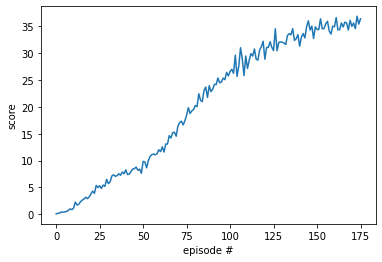

In [11]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('score')
plt.xlabel('episode #')
plt.savefig('ppo_training_history.png')
plt.show()


In order to see a trained agents, we can load the weights and run it!

In [12]:
trained_agent = Agent()
trained_agent.load('ppo.pth')
    
score = evaluate_agent(trained_agent, fast=True)
print("Score: {}".format(score))

Score: 36.09399919323623


When finished, you can close the environment.

In [13]:
env.close()